In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

## First Image

In [2]:
img1_path = './datasets/UnityEyes/imgs/1.jpg'
img1 = cv2.imread(img1_path)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img1_gray = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE)

(600, 800, 3)

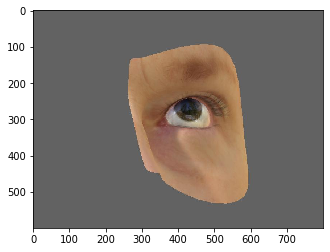

In [3]:
plt.imshow(img1)
img1.shape

(600, 800)

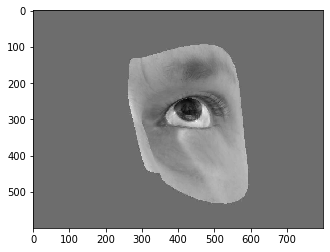

In [4]:
plt.imshow(img1_gray, cmap='gray')
img1_gray.shape

## Image Json Data

In [5]:
import json

with open('./datasets/UnityEyes/imgs/1.json') as json_file:
    json_data = json.load(json_file)
print(json.dumps(json_data, indent=2))

{
  "interior_margin_2d": [
    "(371.4855, 296.4230, 8.8595)",
    "(364.8002, 307.1421, 8.8963)",
    "(377.6998, 328.0000, 8.8956)",
    "(405.9977, 352.2230, 8.9568)",
    "(441.1661, 357.7870, 9.1683)",
    "(467.5667, 342.2133, 9.4351)",
    "(483.2352, 324.5502, 9.6703)",
    "(489.5518, 306.1135, 9.8769)",
    "(489.8072, 291.6013, 10.0333)",
    "(488.4502, 285.3214, 9.8645)",
    "(480.7827, 278.0810, 9.5506)",
    "(465.4229, 275.8344, 9.2366)",
    "(445.8000, 275.4666, 9.0163)",
    "(420.2020, 277.2814, 8.8672)",
    "(392.7874, 280.7436, 8.8285)",
    "(377.1956, 285.5146, 8.8521)"
  ],
  "caruncle_2d": [
    "(364.5717, 284.7197, 8.8818)",
    "(364.8584, 288.3494, 8.8758)",
    "(357.4482, 296.9649, 8.8906)",
    "(349.9624, 289.0576, 8.8963)",
    "(353.7258, 283.3381, 8.8824)",
    "(351.5754, 280.2595, 8.8752)",
    "(346.2976, 282.7485, 8.8394)"
  ],
  "iris_2d": [
    "(389.0269, 332.5428, 8.8831)",
    "(388.8647, 339.9151, 8.9267)",
    "(390.1854, 346.9555, 8.9

32


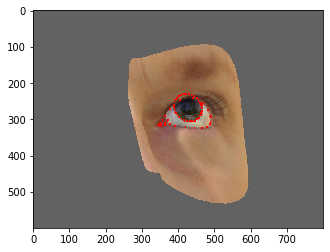

In [6]:
ih, iw = img1_gray.shape
iw_2, ih_2 = 0.5 * iw, 0.5 * ih

def process_coords(coords_list):
    coords = [eval(l) for l in coords_list]
    return np.array([(x, ih-y, z) for (x, y, z) in coords])
interior_landmarks = process_coords(json_data['interior_margin_2d'])
caruncle_landmarks = process_coords(json_data['caruncle_2d'])
iris_landmarks = process_coords(json_data['iris_2d'])

landmarks_img = img1.copy()
print(len(iris_landmarks))
for (x, y, z) in interior_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 3, color=(255, 0, 0), thickness=-1)
for (x, y, z) in caruncle_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 3, color=(255, 0, 0), thickness=-1)
for (x, y, z) in iris_landmarks:
    landmarks_img = cv2.circle(landmarks_img, (int(x), int(y)), 3, color=(255, 0, 0), thickness=-1)
plt.imshow(landmarks_img)
    

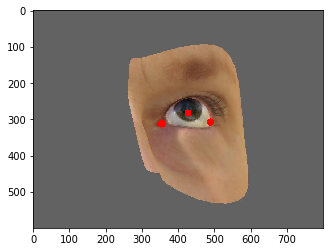

In [7]:
# Prepare to segment eye image
left_corner = np.mean(caruncle_landmarks[:, :2], axis=0)
right_corner = interior_landmarks[8, :2]
eye_width = 1.5 * abs(left_corner[0] - right_corner[0])
eye_middle = np.mean([np.amin(interior_landmarks[:, :2], axis=0),
                      np.amax(interior_landmarks[:, :2], axis=0)], axis=0)

lc = [int(x) for x in left_corner]
rc = [int(x) for x in right_corner]
em = [int(x) for x in eye_middle]
landmarks_img = img1.copy()
landmarks_img = cv2.circle(landmarks_img, tuple(lc), 10, color=(255, 0, 0), thickness=-1)
landmarks_img = cv2.circle(landmarks_img, tuple(rc), 10, color=(255, 0, 0), thickness=-1)
landmarks_img = cv2.circle(landmarks_img, tuple(em), 10, color=(255, 0, 0), thickness=-1)
plt.imshow(landmarks_img)

[[   0.74451381    0.         -243.133506  ]
 [   0.            0.74451381 -165.97526098]]
(90, 150, 3)


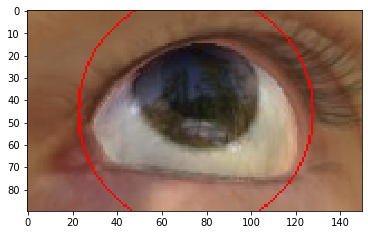

In [8]:
# Re-center so that eye-middle is at the center of the image
ow, oh = 150, 90

scale = ow/eye_width
original_eyeball_radius = 71.7593
eyeball_radius = original_eyeball_radius * scale  # See: https://goo.gl/ZnXgDE
radius = np.float32(eyeball_radius)

recenter_mat = np.zeros((2, 3))
recenter_mat[0, 2] = -eye_middle[0] * scale + 0.5 * ow # * scale_inv
recenter_mat[1, 2] = -eye_middle[1] * scale + 0.5 * oh# * scale_inv
recenter_mat[0, 0] = scale
recenter_mat[1, 1] = scale
print(recenter_mat)
# Apply transforms
eye = cv2.warpAffine(img1, recenter_mat, (ow, oh))
eye = cv2.circle(eye, (int(ow/2), int(oh/2)), int(radius), (255, 0, 0), 1)
plt.imshow(eye)
print(eye.shape)

{'radius': 53.42579, 'gaze': array([ 0.3983306 , -0.37825003], dtype=float32), 'eye': array([[[0.48235297],
        [0.5529413 ],
        [0.5215688 ],
        ...,
        [0.56078446],
        [0.56078446],
        [0.5686276 ]],

       [[0.4901961 ],
        [0.49803925],
        [0.4901961 ],
        ...,
        [0.5294119 ],
        [0.5529413 ],
        [0.56078446]],

       [[0.48235297],
        [0.48235297],
        [0.47450984],
        ...,
        [0.51372564],
        [0.53725505],
        [0.5529413 ]],

       ...,

       [[0.07450986],
        [0.07450986],
        [0.07450986],
        ...,
        [0.53725505],
        [0.53725505],
        [0.53725505]],

       [[0.12941182],
        [0.07450986],
        [0.07450986],
        ...,
        [0.5529413 ],
        [0.53725505],
        [0.53725505]],

       [[0.254902  ],
        [0.07450986],
        [0.07450986],
        ...,
        [0.5529413 ],
        [0.5529413 ],
        [0.53725505]]], dtype=float32), 'la

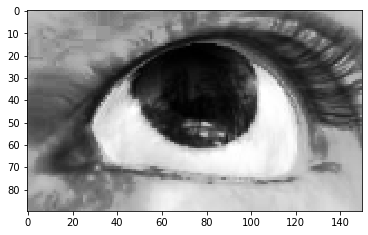

In [18]:
from preprocess import preprocess_unityeyes_image
entry = preprocess_unityeyes_image(90, 150, img1_gray, json_data)
plt.imshow(np.squeeze(entry['eye']), cmap='gray')
print(entry)

In [17]:
mod.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 90, 150, 1)] 0                                            
__________________________________________________________________________________________________
hourglass_pre (Conv2D)          (None, 30, 50, 64)   3200        input_2[0][0]                    
__________________________________________________________________________________________________
hourglass_pre_BatchNorm (BatchN (None, 30, 50, 64)   256         hourglass_pre[0][0]              
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 30, 50, 64)   0           hourglass_pre_BatchNorm[0][0]    
____________________________________________________________________________________________